 # ARIMA based on top x crimes

## Statsforecast autoarima

>https://nixtlaverse.nixtla.io/statsforecast/docs/models/autoarima.html

In [1]:
from datetime import datetime

In [2]:
ROUND_PREDICTIONS = False
SAVE_MODEL_TO_DISK = False
SAVE_DICT_TO_DISK = True
CURRENT_DATE = datetime.now().strftime("%d%m%Y_%H%M")
print("CURRENT_DATE", CURRENT_DATE)

CURRENT_DATE 27112024_1803


## Imports

In [3]:
import pandas as pd
import numpy as np
import os
import pickle
import tqdm

from prophet import Prophet

from sklearn.metrics import root_mean_squared_error

from scipy.stats import shapiro
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Data

In [4]:
base_path = '..\\data\\top_10_crimes\\'

In [5]:
dist_ids = os.listdir(base_path)
dist_ids

['1.0', '2.0', '3.0', '4.0', '5.0', '6.0']

In [6]:
cluster_names = os.listdir(os.path.join(base_path, dist_ids[0]))
print("num_cluster_names", len(cluster_names))

num_cluster_names 10


In [7]:
def load_crime_data(dist_id, offense, subset="train"):
    data_path = f"../data/top_10_crimes/{dist_id}/{offense}/{subset}.csv"
    crime_df = pd.read_csv(data_path, parse_dates=[0], index_col=0)
    return crime_df

In [8]:
crime_dist_dfs = {}
for i, dist_id in enumerate(dist_ids):
    crime_dist_dfs[dist_id] = {}
    for i, cluster_name in enumerate(cluster_names):
        train = load_crime_data(dist_id, cluster_name, subset="train")
        test = load_crime_data(dist_id, cluster_name, subset="test")
        
        # Save final dict
        crime_dist_dfs[dist_id][cluster_name] = {
            "train": train,
            "test": test
        }

In [9]:
print(f"districts in dict: {crime_dist_dfs.keys()}")
print(f"crimes in dict: {crime_dist_dfs["1.0"].keys()}")
print(f"test/train in dict: {crime_dist_dfs["1.0"]['Assault'].keys()}")

districts in dict: dict_keys(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0'])
crimes in dict: dict_keys(['Aggravated Assault', 'Assault', 'Auto Theft', 'Burglary', 'Domestic Assault', 'Domestic Violence', 'Property Damage', 'Sexual Assault', 'Shoplifting', 'Stolen Auto'])
test/train in dict: dict_keys(['train', 'test'])


In [10]:
crime_dist_dfs["1.0"]['Assault']["train"].head()

,Crime_Count
Reported_Date,
2015-01-05,5
2015-01-06,0
2015-01-07,0
2015-01-08,0
2015-01-09,0


### Prepare data for StatsForecast model

In [11]:
# Function to restructure the data
def restructure_for_forecasting(crime_dict):
    unique_id = 1
    for dist_id, crime_data in crime_dict.items():
        for cluster_name, df_types in crime_data.items():
            for df_type, df in df_types.items():
                # Reset index to make Reported_Date a column
                df = df.reset_index(names="Reported_Date")
                # Add unique_id column
                df['unique_id'] = unique_id
                # Rename columns
                df = df.rename(columns={"Reported_Date": "ds", "Crime_Count": "y"})
                # Ensure the date column is in datetime format
                df['ds'] = pd.to_datetime(df['ds'])
                # Reassign the processed dataframe back
                crime_dist_dfs[dist_id][cluster_name][df_type] = df
                unique_id+=1

# Apply the function
restructure_for_forecasting(crime_dist_dfs)

In [12]:
crime_dist_dfs["1.0"]['Assault']["train"].head()

,ds,y,unique_id
0,2015-01-05,5,3
1,2015-01-06,0,3
2,2015-01-07,0,3
3,2015-01-08,0,3
4,2015-01-09,0,3


In [13]:
crime_dist_dfs["1.0"]['Assault']["train"].dtypes

ds           datetime64[ns]
y                     int64
unique_id             int64
dtype: object

### Explore data

In [14]:
df = crime_dist_dfs["1.0"]['Assault']["train"]

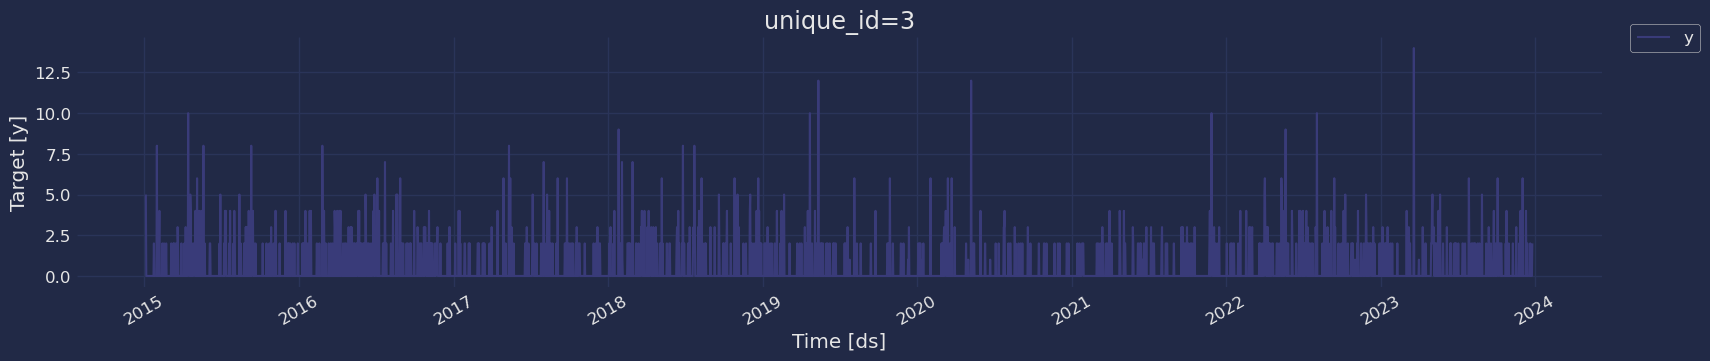

In [15]:
StatsForecast.plot(df)

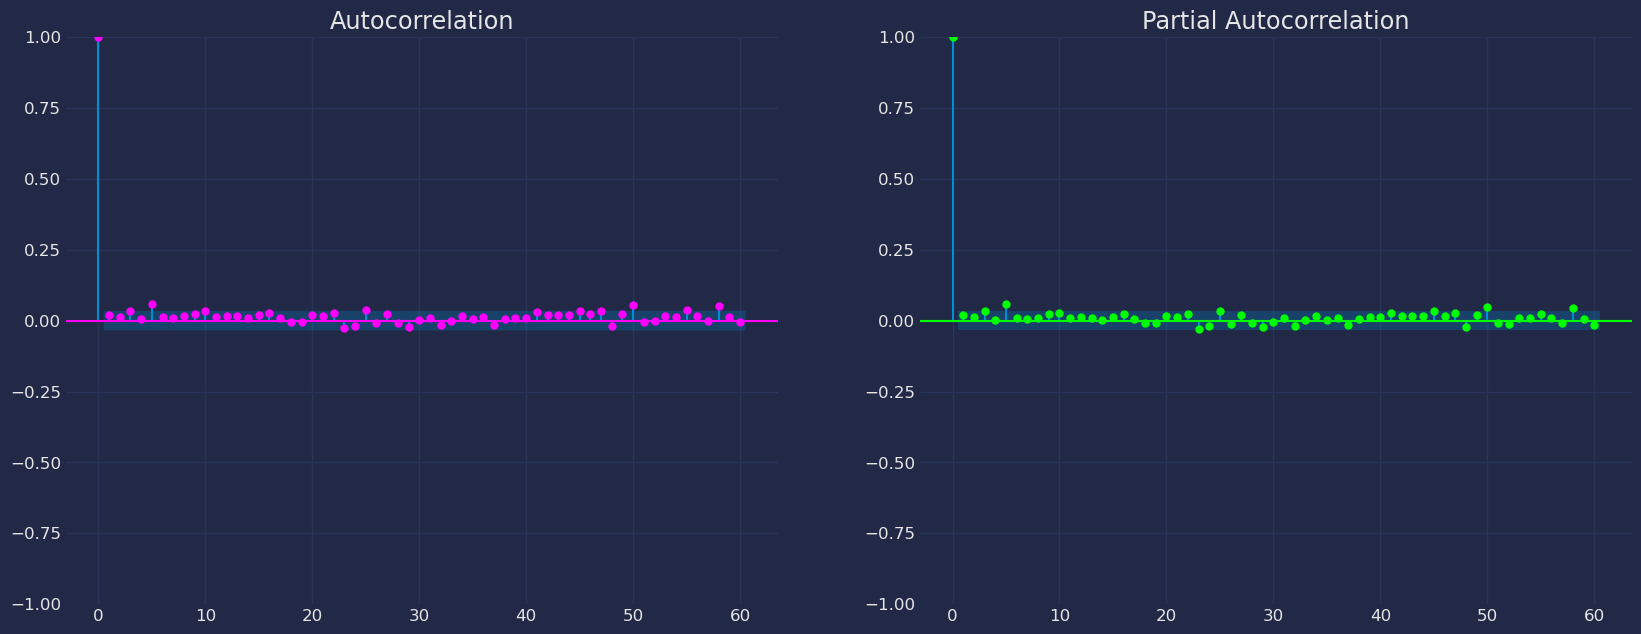

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

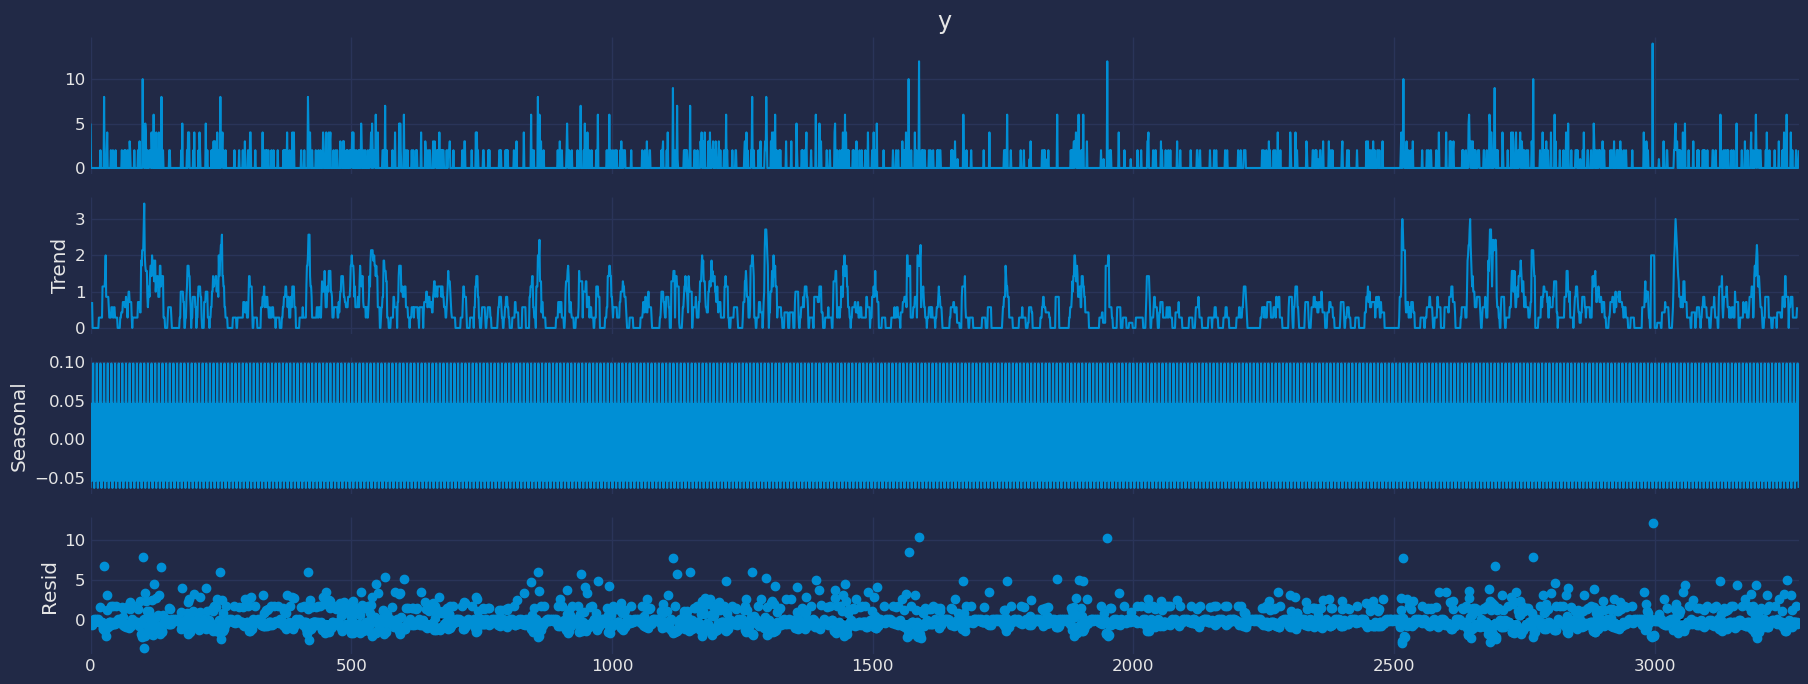

In [17]:
a = seasonal_decompose(df["y"], model = "add", period=7)
a.plot();

18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing


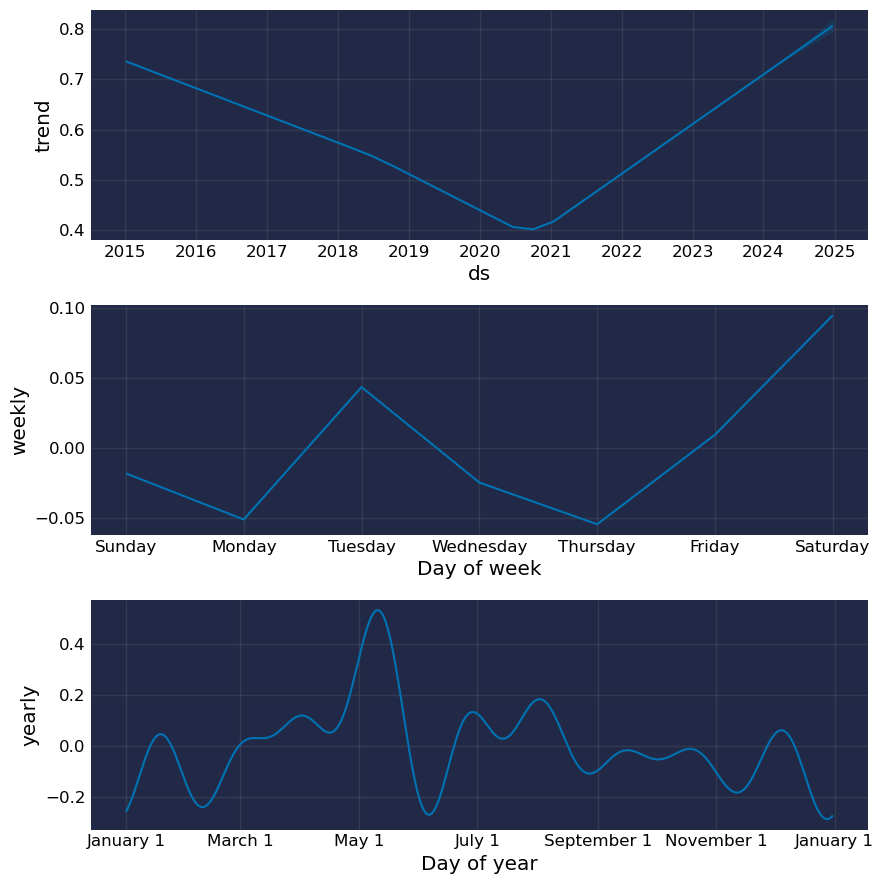

In [18]:
# Prepare data for Prophet
df_prophet = df.copy()
df_prophet = df_prophet.rename(columns={"ds": "ds", "y": "y"})

# Fit the model
model = Prophet()
model.fit(df_prophet)

# Check detected seasonality
future = model.make_future_dataframe(periods=364)
forecast = model.predict(future)

# Plot components
fig = model.plot_components(forecast)

# Customize axis label colors
for ax in fig.axes:  # Iterate over each subplot in the figure
    ax.xaxis.label.set_color("black")  # Set x-axis label color
    ax.yaxis.label.set_color("black")  # Set y-axis label color
    ax.tick_params(axis="x", colors="black")  # Set x-axis tick color
    ax.tick_params(axis="y", colors="black")  # Set y-axis tick color

# Show the updated plot
plt.show()

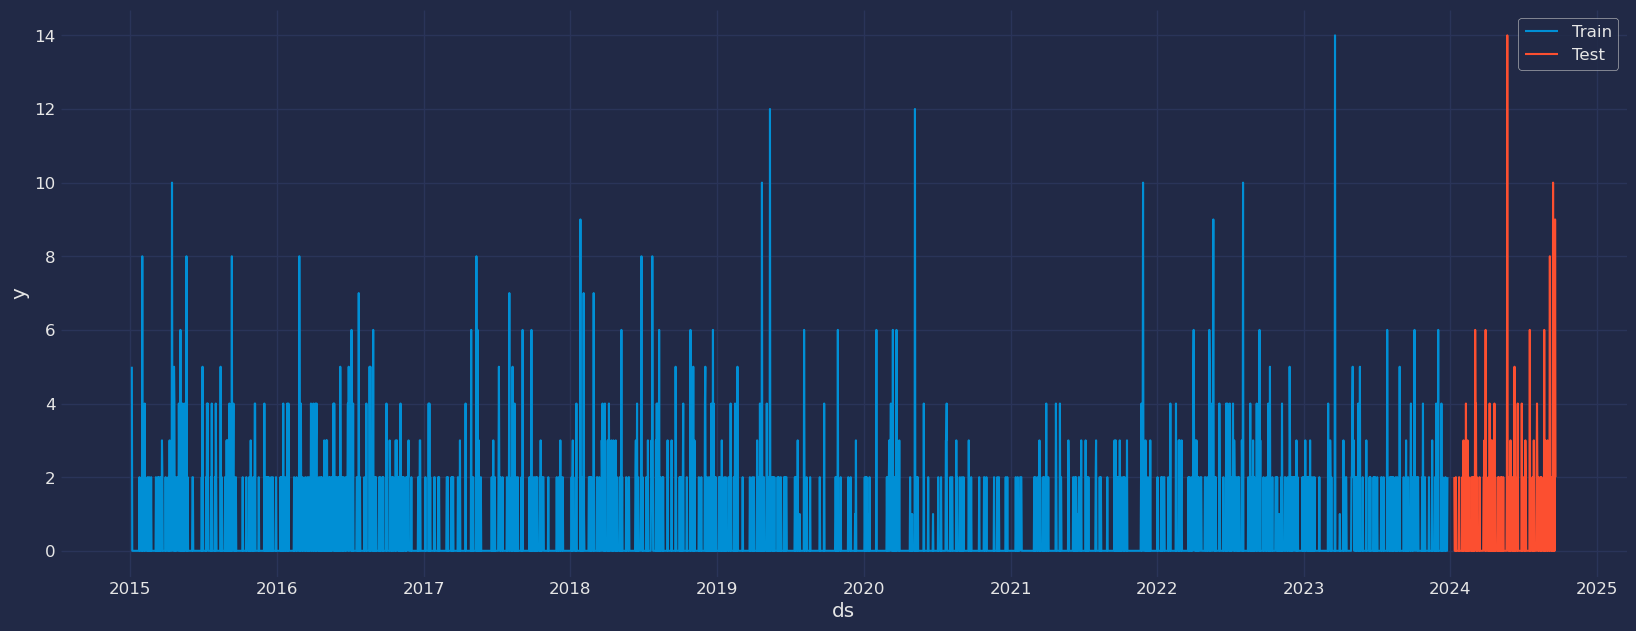

In [19]:
sns.lineplot(crime_dist_dfs["1.0"]['Assault']["train"],x="ds", y="y", label="Train")
sns.lineplot(crime_dist_dfs["1.0"]['Assault']["test"], x="ds", y="y", label="Test")
plt.show()

### Auto arima

In [20]:
def test_adf_stationary(data):
    result = adfuller(data)

    if result[1] > 0.05:
        return False
    else:
        return True

In [ ]:
if SAVE_MODEL_TO_DISK:
    os.makedirs("Arima_models_statsforecast", exist_ok=True)
    print("Created Arima_models_statsforecast directory..")

# Loop through each district and crime category
for dist_id, crimes in crime_dist_dfs.items():
    for cluster_name, data_splits in tqdm.tqdm(crimes.items(), desc=f"dist {dist_id} Crimes", leave=False):
        train_data = data_splits["train"]
        test_data = data_splits["test"]
        
        try:
            # Check if stationary
            #is_stationary = test_adf_stationary(train_data["y"])
            
            season_length = 7  # weekly trend
            horizon = len(test_data) # number of predictions
            models = [AutoARIMA(season_length=season_length)]
            
            sf = StatsForecast(models=models, freq='D', n_jobs=-1)
            
            sf.fit(df=train_data)

            # Save model to disk
            if SAVE_MODEL_TO_DISK:
                model_store_path = os.path.join("Arima_models_statsforecast", str(dist_id), cluster_name)
                os.makedirs(model_store_path, exist_ok=True)
                print(f"Created: {model_store_path} directory..")
                # Serialize with Pickle
                with open(os.path.join(model_store_path, 'arima.pkl'), 'wb') as pkl:
                    pickle.dump(sf, pkl)

            # Terms of model
            result=sf.fitted_[0,0].model_

            # Save model configuration
            crime_dist_dfs[dist_id][cluster_name]["model_config"] = result

            # Get residuals
            residual_df=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
            residuals = residual_df["residual Model"].to_list()

            # Perform Shapiro-Wilk test on residuals
            shapiro_test_statistic, p_value = shapiro(residuals)

            # Interpretation
            if p_value > 0.05:
                raise Exception("**Residuals are normally distributed (fail to reject H0).**")
            
            # Generate predictions
            predictions_df = sf.predict(h=horizon)  # level = [80, 95] add this to get confidence intervals
            crime_dist_dfs[dist_id][cluster_name]["predictions_df"] = predictions_df
            predictions = predictions_df["AutoARIMA"].to_list()
            
            if ROUND_PREDICTIONS:
                # Round predictions to the nearest whole numbers
                predictions = predictions.round()
            
            # Calculate RMSE if test data is available
            if len(test_data) > 0:
                rmse = root_mean_squared_error(test_data['y'], predictions)
                crime_dist_dfs[dist_id][cluster_name]["model_config"]["rmse"] = rmse
            else:
                crime_dist_dfs[dist_id][cluster_name]["model_config"]["rmse"] = None

            crime_dist_dfs[dist_id][cluster_name]["forecast"] = predictions
        
        except Exception as e:
            print(f"ARIMA model failed for district {dist_id}, crime {cluster_name} with error: {e}")
            crime_dist_dfs[dist_id][cluster_name]["model_config"] = None

dist 1.0 Crimes:   0%|          | 0/10 [00:00<?, ?it/s]

#### Plotting

In [22]:
def plot_residuals(residual):
    fig, axs = plt.subplots(nrows=2, ncols=2)

    # plot[1,1]
    residual.plot(ax=axs[0,0])
    axs[0,0].set_title("Residuals");

    # plot
    sns.displot(residual, ax=axs[0,1]);
    axs[0,1].set_title("Density plot - Residual");

    # plot
    stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
    axs[1,0].set_title('Plot Q-Q')

    # plot
    plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
    axs[1,1].set_title("Autocorrelation");

    plt.show();

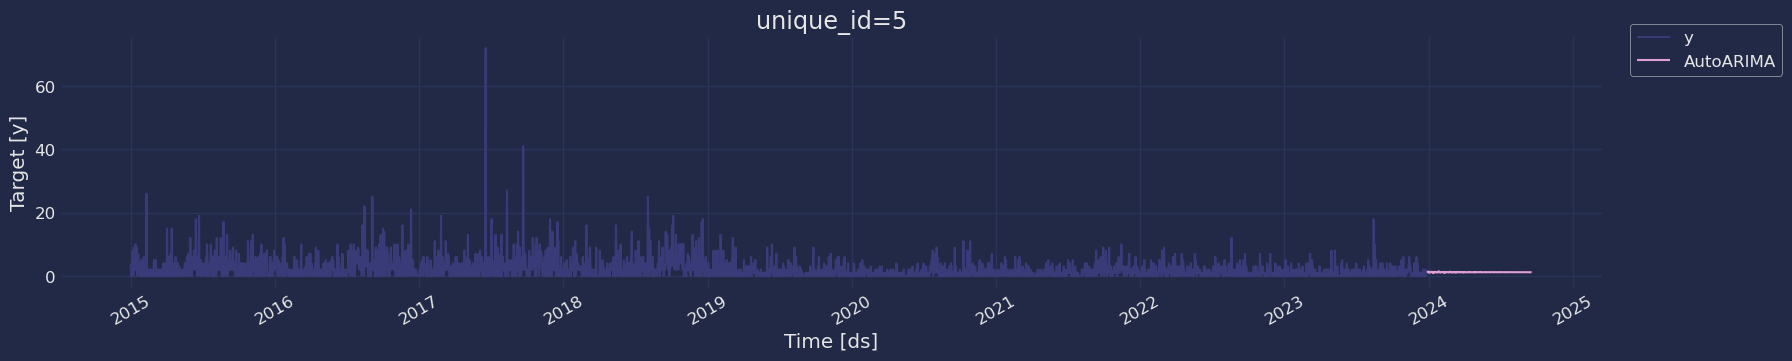

In [26]:
StatsForecast.plot(crime_dist_dfs[district][crime_name]["train"], crime_dist_dfs[district][crime_name]["predictions_df"], max_insample_length=365 * 9)

In [27]:
def plot_aic_values(crime_dist_dfs):
    # Step 1: Get all districts and crimes
    districts = list(crime_dist_dfs.keys())
    num_districts = len(districts)
    crimes = {crime for district in crime_dist_dfs.values() for crime in district.keys()}
    num_crimes = len(crimes)

    # Step 2: Set up subplots based on number of districts and crimes
    fig, axs = plt.subplots(num_districts, 1, figsize=(10, num_districts * 5))
    fig.suptitle('AIC values for Different Crimes across Districts')

    # Step 3: Populate each subplot
    for idx, district in enumerate(districts):
        aic_values = []
        crime_names = []
        
        for crime in crime_dist_dfs[district].keys():
            aic = crime_dist_dfs[district][crime]["model_config"]["aic"]
            aic_values.append(aic)
            crime_names.append(crime)
        
        ax = axs[idx] if num_districts > 1 else axs  # Adjust if single subplot
        ax.bar(crime_names, aic_values)
        ax.set_title(f'AIC values in {district}')
        ax.set_ylabel('AIC')
        ax.set_xlabel('Crime Type')
        ax.set_xticks(crime_names)
        ax.set_xticklabels(crime_names, rotation=25)  # Rotate x-tick labels
        for i, v in enumerate(aic_values):
            ax.text(i, v, f"{v:.2f}", ha='center', va='bottom', fontsize=8)

    plt.tight_layout(rect=[0, 0.02, 1, 0.98])
    plt.show()

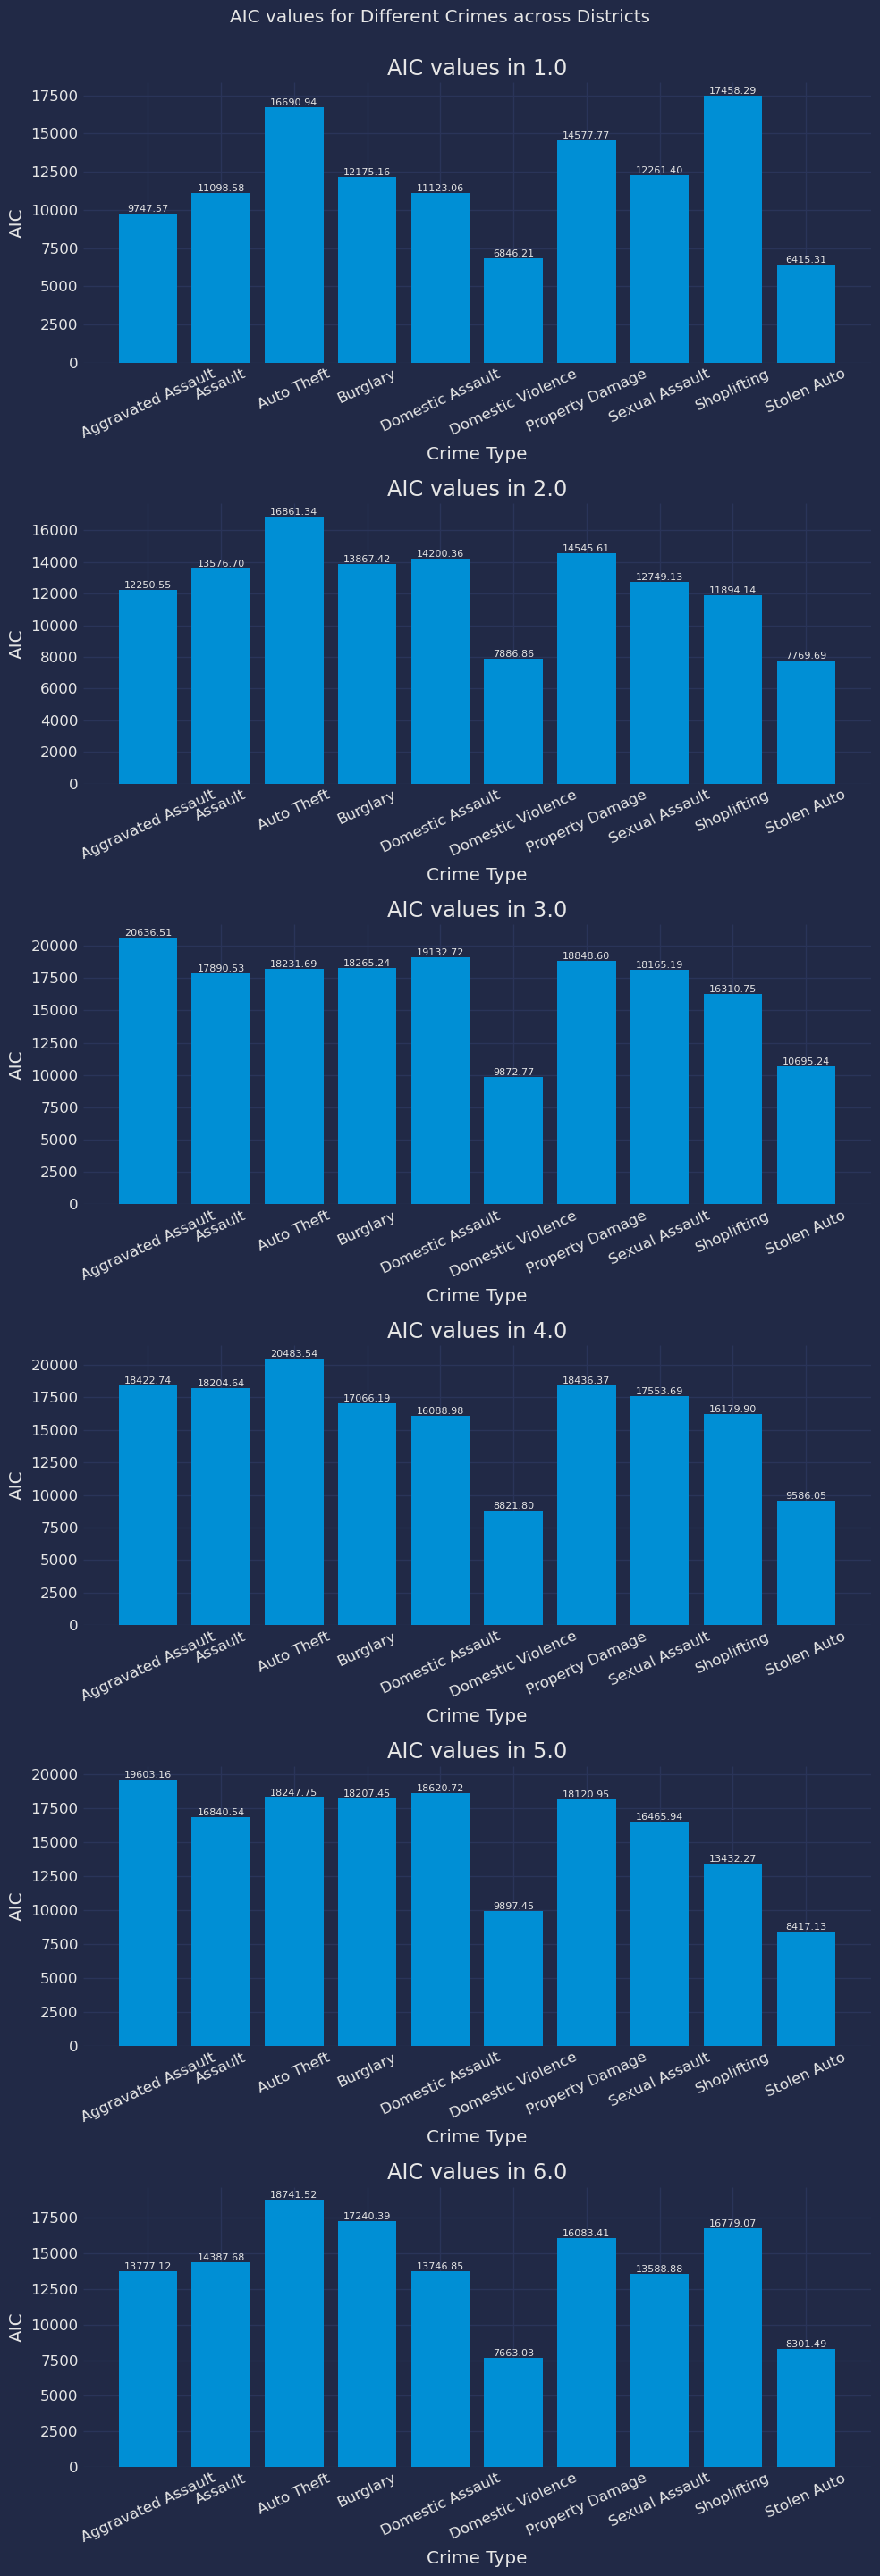

In [28]:
plot_aic_values(crime_dist_dfs)

In [29]:
def plot_rmse_heatmap(crime_dist_dfs):
    """
    Function to create a heatmap plot of RMSE values for crimes across districts
    """
    # Initialize an empty dictionary to hold RMSE values
    rmse_data = {
        "District": [],
        "Crime": [],
        "RMSE": []
    }
    
    # Collect RMSE values for each crime in each district
    for dist_id, crimes in crime_dist_dfs.items():
        for crime_name, crime_info in crimes.items():
            if crime_info.get("model_config") and crime_info["model_config"].get("rmse") is not None:
                rmse_data["District"].append(dist_id)
                rmse_data["Crime"].append(crime_name)
                rmse_data["RMSE"].append(crime_info["model_config"]["rmse"])
    
    # Create a DataFrame from the collected RMSE data
    rmse_df = pd.DataFrame(rmse_data)
    rmse_pivot = rmse_df.pivot(index="Crime", columns="District", values="RMSE")
    
    # Plot the heatmap
    plt.figure(figsize=(8, 8))
    sns.heatmap(rmse_pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'RMSE'})
    plt.title("RMSE of Crime Predictions by District and Crime Category")
    plt.xlabel("District")
    plt.ylabel("Crime Category")
    plt.tight_layout()
    plt.show()

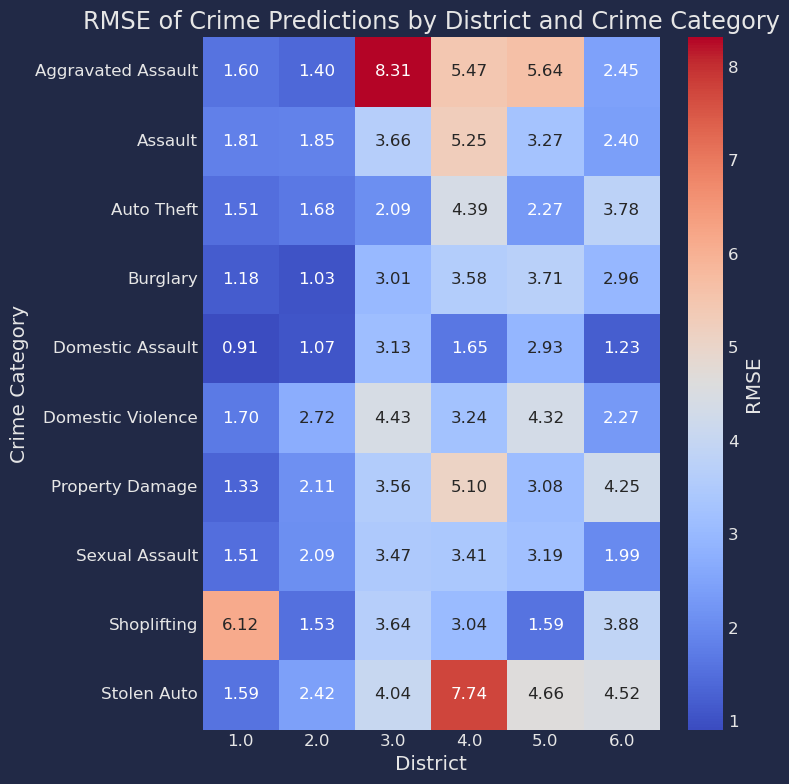

In [30]:
plot_rmse_heatmap(crime_dist_dfs)

In [31]:
if SAVE_DICT_TO_DISK:
    # Save dictionary to a pickle file
    with open(f"..\\data\\mergedData\\statsforecast_crime_dist_dfs_top_10_{CURRENT_DATE}.pkl", 'wb') as file:
        pickle.dump(crime_dist_dfs, file)

In [32]:
# Load dictionary from a pickle file
#with open(f"..\\data\\mergedData\\crime_dist_dfs_top_{TOP_X_CRIMES}.pkl", 'rb') as file:
#    crime_dist_dfs = pickle.load(file)

---